In [ ]:
!pip install rouge_score
!pip install bert_score

In [1]:
import torch
from torch.utils.data import Dataset, random_split
from datasets import load_dataset
import warnings

warnings.filterwarnings("ignore")


dataset = load_dataset("vicgalle/alpaca-gpt4")



train_percentage = 0.90
val_percentage = 0.05  
test_percentage = 0.05 

# Calculate the lengths based on percentages
total_length = len(dataset["train"])
train_length = int(train_percentage * total_length)
val_length = int(val_percentage * total_length)
test_length = total_length - train_length - val_length 


train_dataset, val_dataset, test_dataset = random_split(
    dataset["train"], [train_length, val_length, test_length], generator=torch.manual_seed(42)
)

print(train_length , val_length , test_length, "= ",train_length + val_length + test_length)


def prepare_input(local_dataset):
    inputt = []
    for idx in range(len(local_dataset)):
        inst = local_dataset[idx]['instruction']
        inp = local_dataset[idx]['input']
        if inp != '':
            inputt.append("INSTRUCTION #:# "+ inst+" INPUT #:# "+ inp)
        else:
            inputt.append("INSTRUCTION #:# "+ inst)
    return inputt


  0%|          | 0/1 [00:00<?, ?it/s]

46801 2600 2601 =  52002


In [2]:
index = 3
print("\n=============== Train Example ==============\n")
print(train_dataset[index])
print("\n=============== Validation Example ==============\n")
print(val_dataset[index])
print("\n=============== Test Example ==============\n")
print(test_dataset[index])


=============== Train Example ==============

{'instruction': 'Brainstorm 5 adjectives to describe the following photograph', 'input': 'Photo of a colorful flower field', 'output': '1. Vibrant\n2. Lush\n3. Picturesque\n4. Serene\n5. Majestic', 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nBrainstorm 5 adjectives to describe the following photograph\n\n### Input:\nPhoto of a colorful flower field\n\n### Response:\n1. Vibrant\n2. Lush\n3. Picturesque\n4. Serene\n5. Majestic'}

=============== Validation Example ==============

{'instruction': 'How does the moon affect the tides?', 'input': '', 'output': "The moon affects the tides by its gravitational force pulling on the water in the Earth's oceans. The side of Earth facing the moon will experience a high tide because the moon's gravity pulls water towards it. At the same time, on the opposite si

In [3]:
max(list(map(lambda x: len(x.split()),train_dataset[:]['output'])))

450

# Check output length distribution

<Axes: >

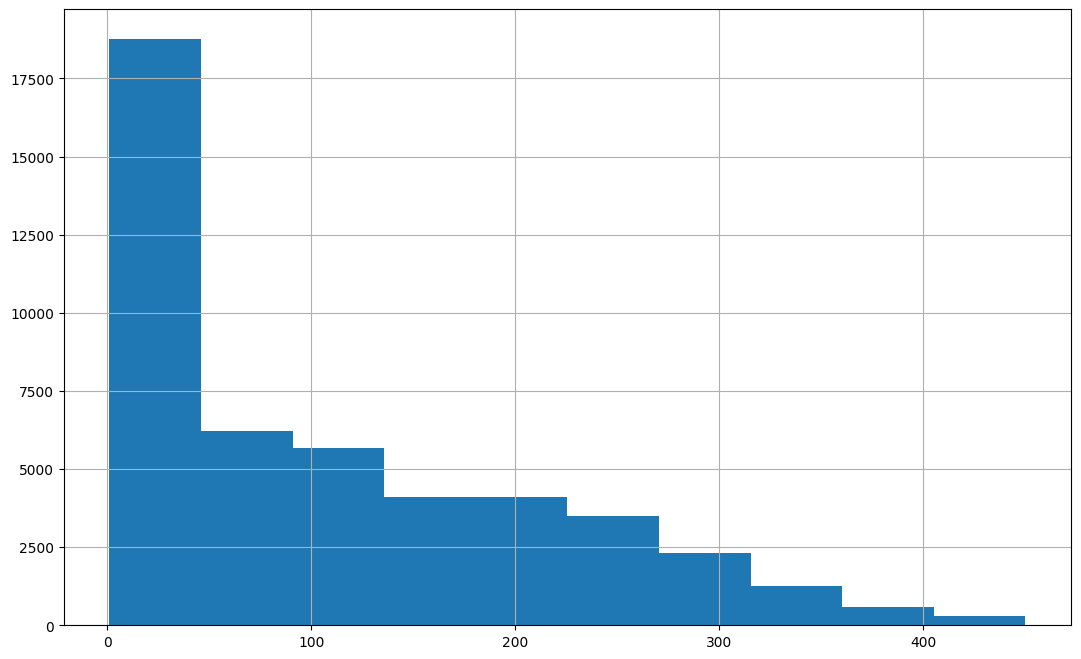

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
_,ax = plt.subplots(figsize=(13,8))
pd.Series(list(map(lambda x: len(x.split()),train_dataset[:]['output']))).hist(ax=ax)

# Data Preparation/ Tokennization

In [5]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, EarlyStoppingCallback
from datasets import Dataset, load_metric
from bert_score import score

# Load the T5 model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


training_dataset = Dataset.from_dict({
    "input_text": prepare_input(train_dataset),
    "target_text": train_dataset[:]['output']
})

eval_dataset = Dataset.from_dict({
    "input_text": prepare_input(val_dataset),
    "target_text": val_dataset[:]['output']
})

testing_dataset = Dataset.from_dict({
    "input_text": prepare_input(test_dataset),
    "target_text": test_dataset[:]['output']
})

max_length = 128
# Tokenize the data and prepare it for training
def tokenize_data(example):
    inputs = tokenizer(example["input_text"], return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    targets = tokenizer(example["target_text"], return_tensors="pt",padding="max_length", truncation=True, max_length=max_length)
    return {
        "input_ids": inputs.input_ids.squeeze().tolist(),
        "attention_mask": inputs.attention_mask.squeeze().tolist(),
        "labels": targets.input_ids.squeeze().tolist(),
    }

batch_size = 100
training_dataset = training_dataset.map(tokenize_data)

eval_dataset = eval_dataset.map(tokenize_data)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


  0%|          | 0/46801 [00:00<?, ?ex/s]

  0%|          | 0/2600 [00:00<?, ?ex/s]

In [8]:
index = 3
print("\n=============== Train Example ==============\n")
print(training_dataset[index])
print("\n=============== Validation Example ==============\n")
print(eval_dataset[index])
print("\n=============== Test Example ==============\n")
print(testing_dataset[index])


=============== Train Example ==============

{'input_text': 'INSTRUCTION #:# Brainstorm 5 adjectives to describe the following photograph INPUT #:# Photo of a colorful flower field', 'target_text': '1. Vibrant\n2. Lush\n3. Picturesque\n4. Serene\n5. Majestic', 'input_ids': [3388, 13733, 6463, 9562, 1713, 10, 4663, 14170, 21556, 305, 31268, 7, 12, 5530, 8, 826, 6419, 27, 9082, 6675, 1713, 10, 4663, 5810, 13, 3, 9, 10540, 5624, 1057, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
metric = load_metric("rouge")

# # Define a custom compute_metrics function
def compute_metrics(p):
    predictions, targets = p.predictions, p.label_ids
    
    decoded_preds = []
    decoded_targets = []
    
    for pred, target in zip(predictions, targets):
        # Filter out token IDs that are out of range
        pred = [token_id for token_id in pred if 0 <= token_id < tokenizer.vocab_size]
        target = [token_id for token_id in target if 0 <= token_id < tokenizer.vocab_size]
        
        if not pred or not target:
            continue  # Skip empty or out-of-range predictions or targets
        
        # Decode the prediction and target sequences individually
        decoded_pred = tokenizer.decode(pred, skip_special_tokens=True)
        decoded_target = tokenizer.decode(target, skip_special_tokens=True)
        
        decoded_preds.append(decoded_pred)
        decoded_targets.append(decoded_target)
    
    rouge_output = metric.compute(predictions=decoded_preds, references=decoded_targets)
    
    return {
        "rouge1_fmeasure": rouge_output["rouge1"].mid.fmeasure,
        "rouge2_fmeasure": rouge_output["rouge2"].mid.fmeasure
    }



# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-finetuned",
    per_device_train_batch_size=10,
    num_train_epochs=2,
    learning_rate=0.0001,
    evaluation_strategy="steps",
    eval_steps=4000,
    logging_steps=4000,
    save_strategy="steps",
    save_steps=4000,
    logging_dir=None,
    report_to="none",
    #greater_is_better=True,
    save_total_limit=2,
    predict_with_generate=True,
    load_best_model_at_end=True,
    generation_max_length=512,
    generation_num_beams=1,
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding="max_length",
    max_length=100,
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator, 
    train_dataset=training_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [15]:
trainer.train()

Step,Training Loss,Validation Loss,Rouge1 Fmeasure,Rouge2 Fmeasure
4000,1.366900,1.227358,0.364291,0.173273
8000,1.321000,1.200793,0.380041,0.182250


TrainOutput(global_step=9362, training_loss=1.3380994301681666, metrics={'train_runtime': 5587.8794, 'train_samples_per_second': 16.751, 'train_steps_per_second': 1.675, 'total_flos': 1.6023664425959424e+16, 'train_loss': 1.3380994301681666, 'epoch': 2.0})

In [ ]:
trainer.save_model()

In [ ]:
test_dataset = test_data.map(tokenize_data)